In [7]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

file_path = "/Users/zhuoshangming/Desktop/513/无敌认真final/ConfLongDemo_JSI.csv"
df = pd.read_csv(file_path)

df.columns = ['Person', 'Sensor_ID', 'Timestamp', 'Datetime', 'X', 'Y', 'Z', 'Activity']

df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d.%m.%Y %H:%M:%S:%f')

df = df.sort_values(by=['Person', 'Datetime'])

final_df_list = []

for (person, activity), group in df.groupby(['Person', 'Activity']):
    sensor_counts = group['Sensor_ID'].value_counts()
    max_sensor = sensor_counts.idxmax()
    max_count = sensor_counts.max()

    ref_times = group[group['Sensor_ID'] == max_sensor]['Datetime'].values

    interpolated_data = pd.DataFrame({'Person': person, 'Datetime': ref_times, 'Activity': activity})

    for sensor in sensor_counts.index:
        sensor_data = group[group['Sensor_ID'] == sensor]

        matched_indices = np.searchsorted(sensor_data['Datetime'].values, ref_times, side='left')
        matched_indices = np.clip(matched_indices, 0, len(sensor_data) - 1)  # 避免越界

        matched_x = sensor_data.iloc[matched_indices]['X'].values
        matched_y = sensor_data.iloc[matched_indices]['Y'].values
        matched_z = sensor_data.iloc[matched_indices]['Z'].values

        interpolated_data[f'X_{sensor}'] = matched_x
        interpolated_data[f'Y_{sensor}'] = matched_y
        interpolated_data[f'Z_{sensor}'] = matched_z

    for col in interpolated_data.columns[3:]:
        valid = ~pd.isna(interpolated_data[col])
        if valid.sum() > 1: 
            interp_func = interp1d(interpolated_data['Datetime'][valid].astype(int),
                                   interpolated_data[col][valid],
                                   kind='linear', fill_value='extrapolate')
            interpolated_data[col] = interp_func(interpolated_data['Datetime'].astype(int))

    final_df_list.append(interpolated_data)

final_df = pd.concat(final_df_list, ignore_index=True)

output_file_path = "/Users/zhuoshangming/Desktop/513/无敌认真final/增强后补全代码（4个传感器数据合并在同一时间）.csv" 
final_df.to_csv(output_file_path, index=False)

print(f"数据已处理并保存至 {output_file_path}")

数据已处理并保存至 /Users/zhuoshangming/Desktop/513/无敌认真final/增强后补全代码（4个传感器数据合并在同一时间）.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# =========================================
# 1. SPLIT TRAIN/TEST BY PERSON
# =========================================

# Suppose `final_df` is already created by your preprocessing code.
# Columns: [Person, Datetime, Activity, X_010-..., Y_010-..., Z_010-..., ...]
# Make sure final_df is sorted by (Person, Datetime) if needed:
# final_df = final_df.sort_values(by=['Person', 'Datetime']).reset_index(drop=True)

unique_persons = final_df['Person'].unique()
np.random.shuffle(unique_persons)  # shuffle to avoid any ordering bias

# train_size = int(0.8 * len(unique_persons))
# train_persons = unique_persons[:train_size]
# test_persons = unique_persons[train_size:]

train_persons = ['D03', 'B05', 'E05', 'A05', 'B01', 'A04', 'C02', 'B04', 'E02', 'C01', 'D01', 'A01', 'A03', 'B03', 'C04', 'D05', 'D02', 'A02', 'E01', 'B02']
test_persons = ['E03', 'D04', 'C05', 'E04', 'C03']

print(train_persons, test_persons)


train_df = final_df[final_df['Person'].isin(train_persons)].copy()
test_df = final_df[final_df['Person'].isin(test_persons)].copy()

print(f"Unique persons: {len(unique_persons)}")
print(f"Train persons: {len(train_persons)} | Test persons: {len(test_persons)}")

# =========================================
# 2. GENERATE SLIDING WINDOWS PER (PERSON, ACTIVITY)
# =========================================

def generate_sliding_windows(df, window_size=10, step_size=1):
    """
    Create overlapping sliding windows from data grouped by (Person, Activity).
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame with columns:
        [Person, Datetime, Activity, X_..., Y_..., Z_..., ...].
    window_size : int
        Number of consecutive samples in each window.
    step_size : int
        The step (stride) with which we move the sliding window.
    
    Returns
    -------
    X_list : list of np.ndarray
        Each element is a 2D array (window_size x number_of_features).
    y_list : list
        Activity label for each window.
    person_list : list
        Person ID for each window (optional – helps in tracking).
    """
    X_list = []
    y_list = []
    person_list = []
    
    # Group by Person, Activity to avoid crossing boundaries
    for (person, activity), group in df.groupby(['Person', 'Activity']):
        # Sort by Datetime (if not already sorted)
        group = group.sort_values(by='Datetime')
        
        # We will use all sensor columns (i.e., everything except the first three: Person, Datetime, Activity)
        sensor_columns = group.columns[3:]
        
        # Convert to numpy for faster slicing
        sensor_data = group[sensor_columns].values
        
        # Slide in steps of step_size, but only if we can fit a full window_size
        for start_idx in range(0, len(sensor_data) - window_size + 1, step_size):
            end_idx = start_idx + window_size
            window_slice = sensor_data[start_idx:end_idx]
            
            X_list.append(window_slice)
            y_list.append(activity)
            person_list.append(person)
    
    return X_list, y_list, person_list

# Example usage:
train_X_list, train_y_list, train_person_list = generate_sliding_windows(train_df, 
                                                                         window_size=30, 
                                                                         step_size=1)

test_X_list, test_y_list, test_person_list = generate_sliding_windows(test_df, 
                                                                      window_size=30, 
                                                                      step_size=1)

print(f"Number of training windows: {len(train_X_list)}")
print(f"Number of testing windows: {len(test_X_list)}")

# If you need them as numpy arrays (common for deep learning frameworks):
X_train = np.array(train_X_list)  # shape: [num_windows, window_size, num_sensors]
y_train = np.array(train_y_list)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_test = np.array(test_X_list)
y_test = np.array(test_y_list)

print("train_X shape:", X_train.shape)
print("train_y shape:", y_train.shape)

['D03', 'B05', 'E05', 'A05', 'B01', 'A04', 'C02', 'B04', 'E02', 'C01', 'D01', 'A01', 'A03', 'B03', 'C04', 'D05', 'D02', 'A02', 'E01', 'B02'] ['E03', 'D04', 'C05', 'E04', 'C03']
Unique persons: 25
Train persons: 20 | Test persons: 5
Number of training windows: 31827
Number of testing windows: 8861
train_X shape: (31827, 30, 12)
train_y shape: (31827,)


['falling' 'lying' 'lying down' 'on all fours' 'sitting' 'sitting down'
 'sitting on the ground' 'standing up from lying'
 'standing up from sitting' 'standing up from sitting on the ground'
 'walking']
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


995/995 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.3897 - loss: 1.6525 - val_accuracy: 0.5460 - val_loss: 0.9969 - learning_rate: 0.0100
Epoch 2/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.6848 - loss: 0.8176 - val_accuracy: 0.8833 - val_loss: 0.4106 - learning_rate: 0.0100
Epoch 3/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.8529 - loss: 0.4838 - val_accuracy: 0.8944 - val_loss: 0.3486 - learning_rate: 0.0100
Epoch 4/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8874 - loss: 0.3634 - val_accuracy: 0.9069 - val_loss: 0.2711 - learning_rate: 0.0100
Epoch 5/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9052 - loss: 0.2979 - val_accuracy: 0.8992 - val_loss: 0.2789 - learning_rate: 0.0100
Epoch 6/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9209 - loss: 0.2569 - val_accuracy: 0.9263 - val_loss: 0.2490 - learning_rate: 0.0100
Epoch 7/50
995/995 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.9318 - loss: 0.2201

✅ 模型已保存: /Users/zhuoshangming/Desktop/513/无敌认真final/preprocessed_data/lstm_activity_model.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
🎯 测试集准确率: 0.9687


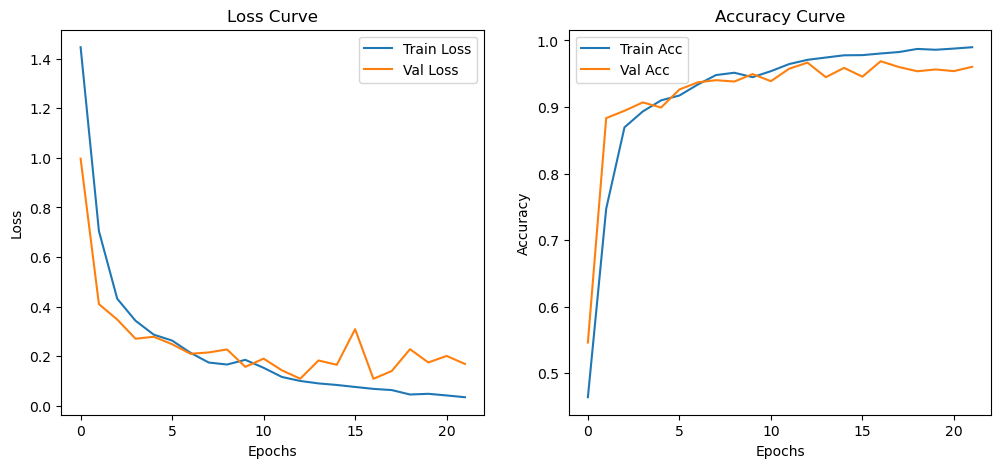

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, SimpleRNN, GRU
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import accuracy_score
import os
from sklearn.preprocessing import LabelEncoder

data_dir = "/Users/zhuoshangming/Desktop/513/无敌认真final/preprocessed_data"
os.makedirs(data_dir, exist_ok=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
label_classes=label_encoder.classes_
print(label_classes)

# model = Sequential([
#     GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.3),
#     GRU(64, return_sequences=True),
#     Dropout(0.3),
#     GRU(32),
#     Dropout(0.3),
#     Dense(32, activation=LeakyReLU(alpha=0.01)),
#     Dense(len(label_classes), activation='softmax')
# ])

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation=LeakyReLU(alpha=0.01)),
    Dense(len(label_classes), activation='softmax')
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

callback_lr = LearningRateScheduler(lr_scheduler)
callback_early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[callback_lr, callback_early_stop]
)

model.save(f"{data_dir}/lstm_activity_model.h5")
print(f"✅ 模型已保存: {data_dir}/lstm_activity_model.h5")

y_pred = np.argmax(model.predict(X_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"🎯 测试集准确率: {test_acc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [ ]:
# Using ChatGPT to assist with code debugging.